# Taiwan Election Prediction: Predictive Modeling

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Machine learning libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score
import xgboost as xgb

warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')
sns.set_palette('husl')

## 1. Load and Prepare Data

In [4]:
# Load cleaned data
df = pd.read_csv('../data/processed/cleaned_data.csv')

print(f"Data shape: {df.shape}")
print(f"\nTarget variable distribution:")
print(df['Winner'].value_counts())

df.head()

Data shape: (20, 30)

Target variable distribution:
Winner
Lai_Hsiao    14
Hou_Chao      6
Name: count, dtype: int64


,District,Winner,Total_Votes,Ko_Wu,Ko_Wu_Pct,Lai_Hsiao,Lai_Hsiao_Pct,Hou_Chao,Hou_Chao_Pct,Total_Population,...,Avg_People_Per_HH,Total_15Plus,Higher_Education_Pct,Graduate_Pct,College_Pct,JuniorCollege_Pct,HighSchool_Pct,Junior_Pct,Primary_Pct,Illiterate_Pct
0,Taipei City,Lai_Hsiao,1542011,366854,23.79,587899,38.13,587258,38.08,4041869.0,...,2.71,2187844,65.72,15.25,38.23,12.24,21.97,6.24,5.69,0.39
1,New Taipei City,Lai_Hsiao,2458480,645105,26.24,948818,38.59,864557,35.17,2511291.0,...,2.75,3601907,51.90,8.59,31.64,11.67,28.58,11.71,7.26,0.55
2,Taoyuan City,Lai_Hsiao,1350792,413528,30.61,476441,35.27,460823,34.12,2319118.0,...,2.99,2024131,51.55,8.44,32.43,10.68,30.55,10.22,7.05,0.63
3,Taichung City,Lai_Hsiao,1707203,513025,30.05,641622,37.58,552556,32.37,2847264.0,...,2.82,2488030,52.67,8.98,32.45,11.24,29.31,10.02,7.37,0.64
4,Tainan City,Lai_Hsiao,1120238,262560,23.44,570811,50.95,286867,25.61,1859800.0,...,2.81,1650022,49.01,8.81,30.34,9.85,28.30,10.95,10.90,0.85


In [5]:
# Select features for modeling
feature_cols = [
    # Age structure
    'Age_0_14_Pct', 'Age_15_64_Pct', 'Age_65_Plus_Pct',
    # Economic factors
    'Income', 'Disposable_Income', 'Consumption',
    # Education
    'Higher_Education_Pct', 'Graduate_Pct',
    # Household
    'Avg_People_Per_HH'
]

X = df[feature_cols]
y = df['Winner']

print(f"Features: {len(feature_cols)}")
print(f"Samples: {len(X)}")
print(f"\nFeature list:")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

Features: 9
Samples: 20

Feature list:
  1. Age_0_14_Pct
  2. Age_15_64_Pct
  3. Age_65_Plus_Pct
  4. Income
  5. Disposable_Income
  6. Consumption
  7. Higher_Education_Pct
  8. Graduate_Pct
  9. Avg_People_Per_HH


In [6]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set: {len(X_train)} samples")
print(f"Test set: {len(X_test)} samples")
print(f"\nTraining set distribution:")
print(y_train.value_counts())
print(f"\nTest set distribution:")
print(y_test.value_counts())

Training set: 14 samples
Test set: 6 samples

Training set distribution:
Winner
Lai_Hsiao    10
Hou_Chao      4
Name: count, dtype: int64

Test set distribution:
Winner
Lai_Hsiao    4
Hou_Chao     2
Name: count, dtype: int64


In [7]:
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Features scaled successfully!")
print(f"\nScaled feature means:")
print(np.mean(X_train_scaled, axis=0).round(3))
print(f"\nScaled feature std devs:")
print(np.std(X_train_scaled, axis=0).round(3))

Features scaled successfully!

Scaled feature means:
[-0. -0. -0. -0. -0. -0.  0. -0. -0.]

Scaled feature std devs:
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


## 2. Model Training

### 2.1 Logistic Regression (Baseline)

In [8]:
# Train logistic regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_lr = lr_model.predict(X_test_scaled)
y_pred_proba_lr = lr_model.predict_proba(X_test_scaled)

# Accuracy
lr_accuracy = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {lr_accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 66.67%

Classification Report:
              precision    recall  f1-score   support

    Hou_Chao       0.00      0.00      0.00         2
   Lai_Hsiao       0.67      1.00      0.80         4

    accuracy                           0.67         6
   macro avg       0.33      0.50      0.40         6
weighted avg       0.44      0.67      0.53         6



### 2.2 Random Forest

In [9]:
# Train Random Forest
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    min_samples_split=2,
    random_state=42
)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)

# Accuracy
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Accuracy: {rf_accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Random Forest Accuracy: 33.33%

Classification Report:
              precision    recall  f1-score   support

    Hou_Chao       0.00      0.00      0.00         2
   Lai_Hsiao       0.50      0.50      0.50         4

    accuracy                           0.33         6
   macro avg       0.25      0.25      0.25         6
weighted avg       0.33      0.33      0.33         6



### 2.3 XGBoost

In [10]:
# Encode target labels for XGBoost
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# Train XGBoost
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42,
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train_encoded)

# Predictions
y_pred_xgb_encoded = xgb_model.predict(X_test)
y_pred_xgb = le.inverse_transform(y_pred_xgb_encoded)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)

# Accuracy
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"XGBoost Accuracy: {xgb_accuracy:.2%}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 50.00%

Classification Report:
              precision    recall  f1-score   support

    Hou_Chao       0.00      0.00      0.00         2
   Lai_Hsiao       0.60      0.75      0.67         4

    accuracy                           0.50         6
   macro avg       0.30      0.38      0.33         6
weighted avg       0.40      0.50      0.44         6



## 3. Model Comparison


Model Performance Comparison
              Model  Accuracy
Logistic Regression  0.666667
            XGBoost  0.500000
      Random Forest  0.333333


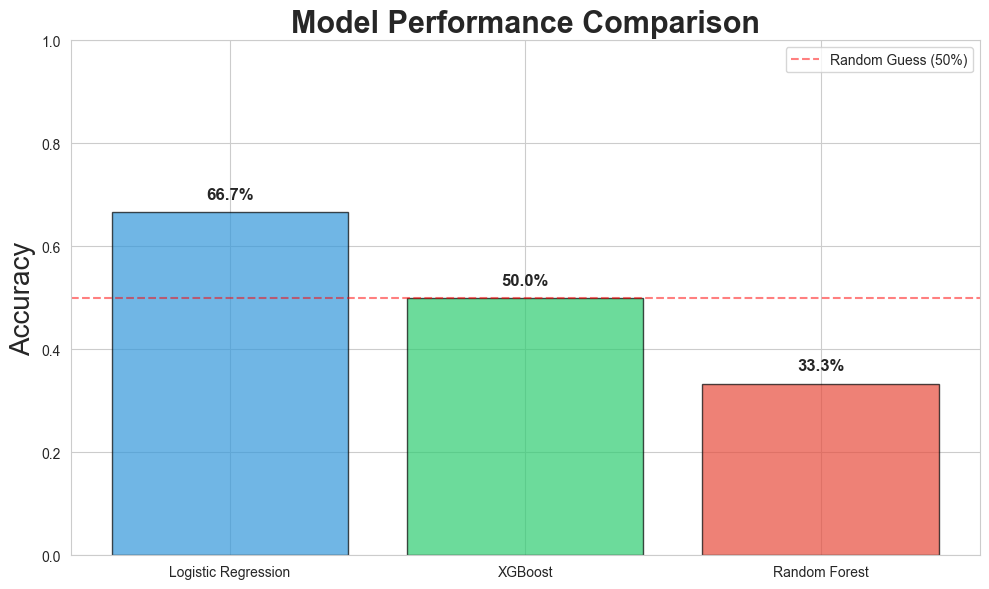

In [11]:
# Compare model accuracies
model_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_accuracy, rf_accuracy, xgb_accuracy]
})

model_comparison = model_comparison.sort_values('Accuracy', ascending=False)

print("\n" + "="*50)
print("Model Performance Comparison")
print("="*50)
print(model_comparison.to_string(index=False))

# Visualize comparison
plt.figure(figsize=(10, 6))
bars = plt.bar(model_comparison['Model'], model_comparison['Accuracy'], 
               color=['#3498db', '#2ecc71', '#e74c3c'], alpha=0.7, edgecolor='black')
plt.ylabel('Accuracy', fontsize=20)
plt.title('Model Performance Comparison', fontsize=22, fontweight='bold')
plt.ylim(0, 1.0)
plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Guess (50%)')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.02,
             f'{height:.1%}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.legend()
plt.tight_layout()
plt.savefig('../results/figures/model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

## 4. Feature Importance Analysis

### 4.1 Random Forest Feature Importance


Random Forest - Top 5 Most Important Features:
          Feature  Importance
Avg_People_Per_HH    0.175457
     Age_0_14_Pct    0.146016
  Age_65_Plus_Pct    0.124030
           Income    0.121733
    Age_15_64_Pct    0.096704


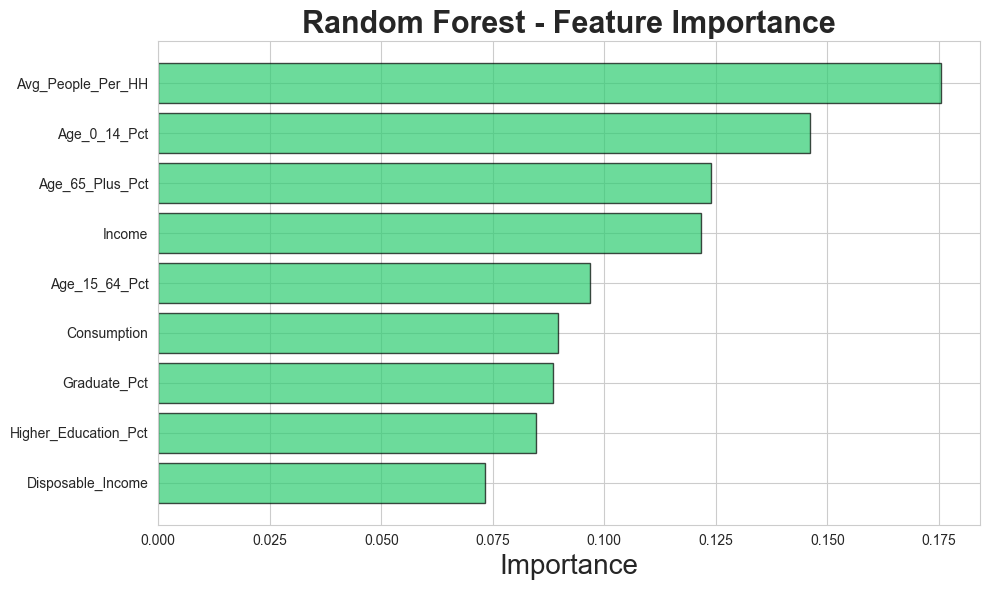

In [12]:
# Get feature importance from Random Forest
feature_importance_rf = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nRandom Forest - Top 5 Most Important Features:")
print(feature_importance_rf.head().to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_rf['Feature'], feature_importance_rf['Importance'], 
         color='#2ecc71', alpha=0.7, edgecolor='black')
plt.xlabel('Importance', fontsize=20)
plt.title('Random Forest - Feature Importance', fontsize=22, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/feature_importance_rf.png', dpi=300, bbox_inches='tight')
plt.show()

### 4.2 XGBoost Feature Importance


XGBoost - Top 5 Most Important Features:
             Feature  Importance
         Consumption    0.329175
Higher_Education_Pct    0.289837
       Age_15_64_Pct    0.277038
   Avg_People_Per_HH    0.103950
        Age_0_14_Pct    0.000000


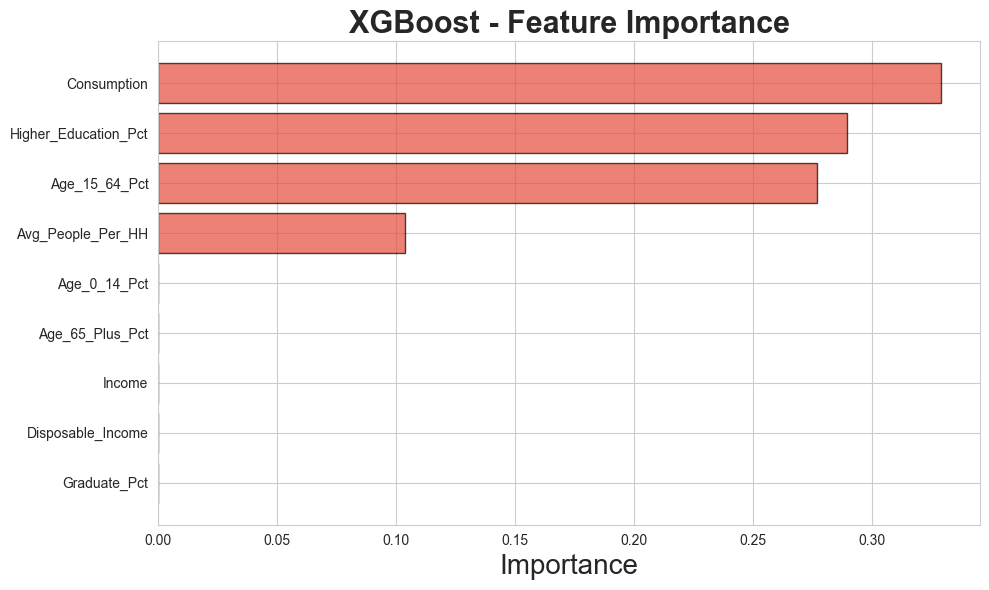

In [13]:
# Get feature importance from XGBoost
feature_importance_xgb = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nXGBoost - Top 5 Most Important Features:")
print(feature_importance_xgb.head().to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_xgb['Feature'], feature_importance_xgb['Importance'], 
         color='#e74c3c', alpha=0.7, edgecolor='black')
plt.xlabel('Importance', fontsize=20)
plt.title('XGBoost - Feature Importance', fontsize=22, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../results/figures/feature_importance_xgb.png', dpi=300, bbox_inches='tight')
plt.show()

## 5. Confusion Matrix Visualization

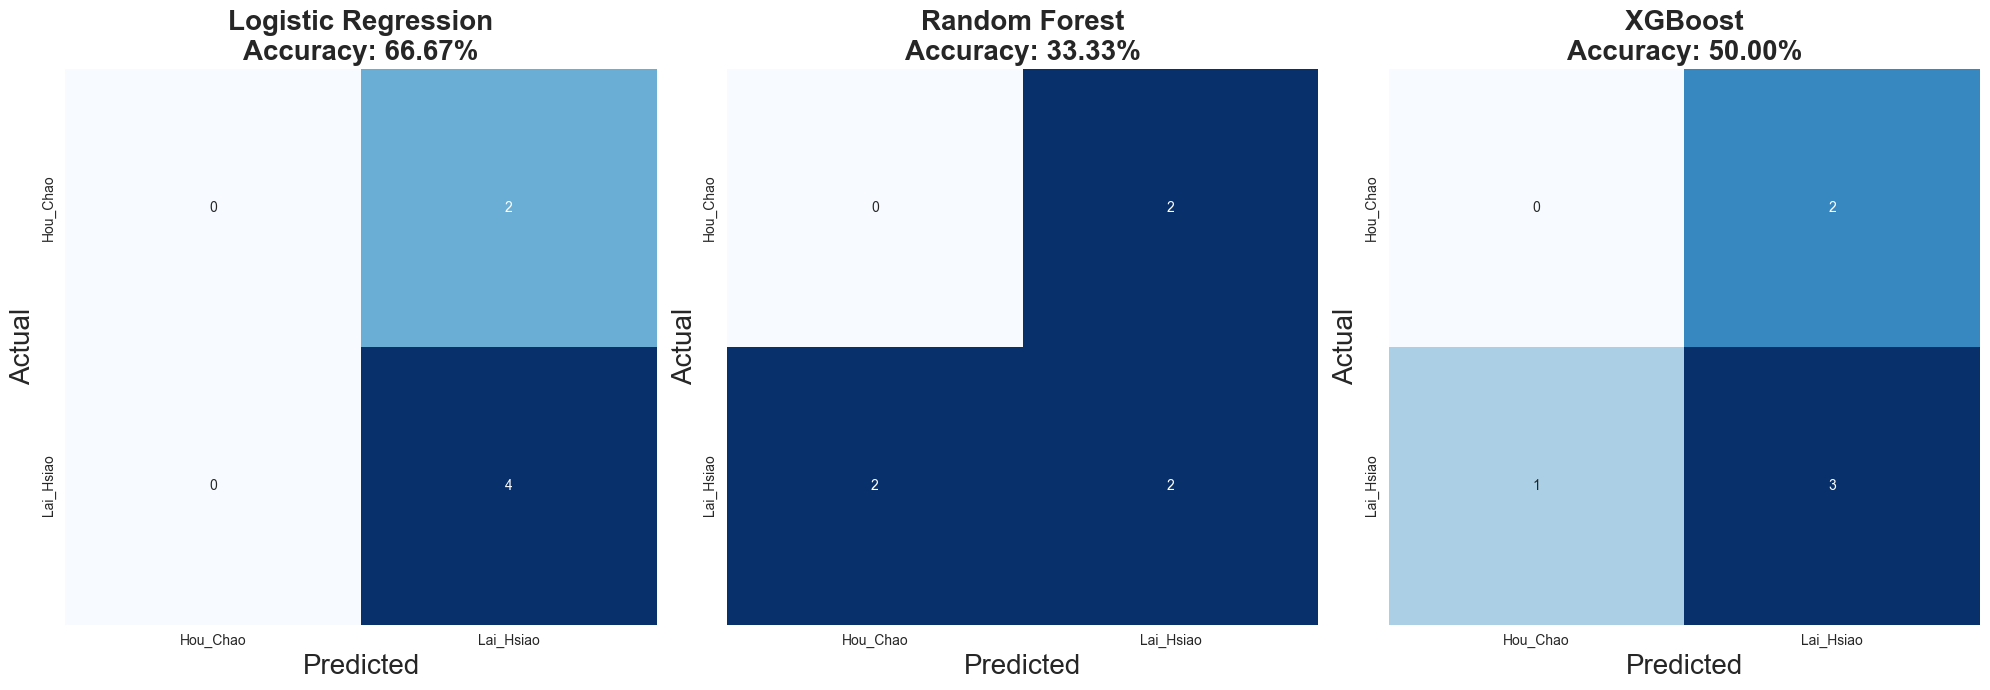

In [14]:
# Plot confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(20, 7))

models = [
    ('Logistic Regression', y_pred_lr),
    ('Random Forest', y_pred_rf),
    ('XGBoost', y_pred_xgb)
]

class_labels = le.classes_
for idx, (model_name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_labels, 
                yticklabels=class_labels,
                ax=axes[idx], cbar=False)
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {accuracy_score(y_test, y_pred):.2%}', 
                        fontsize=20, fontweight='bold')
    axes[idx].set_xlabel('Predicted', fontsize=20)
    axes[idx].set_ylabel('Actual', fontsize=20)

plt.tight_layout()
plt.savefig('../results/figures/confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## 6. Prediction Analysis

In [15]:
# Create prediction comparison dataframe
predictions_df = pd.DataFrame({
    'District': df.loc[X_test.index, 'District'].values,
    'Actual': y_test.values,
    'LR_Pred': y_pred_lr,
    'RF_Pred': y_pred_rf,
    'XGB_Pred': y_pred_xgb
})

# Add correct prediction indicators
predictions_df['LR_Correct'] = (predictions_df['Actual'] == predictions_df['LR_Pred'])
predictions_df['RF_Correct'] = (predictions_df['Actual'] == predictions_df['RF_Pred'])
predictions_df['XGB_Correct'] = (predictions_df['Actual'] == predictions_df['XGB_Pred'])

print("\nPrediction Results by District:")
print(predictions_df.to_string(index=False))

# Identify misclassified districts
print("\n" + "="*50)
print("Misclassified Districts Analysis")
print("="*50)

for model_name, pred_col, correct_col in [('Random Forest', 'RF_Pred', 'RF_Correct'),
                                            ('XGBoost', 'XGB_Pred', 'XGB_Correct')]:
    misclassified = predictions_df[~predictions_df[correct_col]]
    if len(misclassified) > 0:
        print(f"\n{model_name} Misclassifications:")
        print(misclassified[['District', 'Actual', pred_col]].to_string(index=False))
    else:
        print(f"\n{model_name}: Perfect predictions!")


Prediction Results by District:
      District    Actual   LR_Pred   RF_Pred  XGB_Pred  LR_Correct  RF_Correct  XGB_Correct
Hualien County  Hou_Chao Lai_Hsiao Lai_Hsiao Lai_Hsiao       False       False        False
  Yilan County Lai_Hsiao Lai_Hsiao Lai_Hsiao Lai_Hsiao        True        True         True
Taitung County  Hou_Chao Lai_Hsiao Lai_Hsiao Lai_Hsiao       False       False        False
   Tainan City Lai_Hsiao Lai_Hsiao Lai_Hsiao  Hou_Chao        True        True        False
  Hsinchu City Lai_Hsiao Lai_Hsiao  Hou_Chao Lai_Hsiao        True       False         True
 Chiayi County Lai_Hsiao Lai_Hsiao  Hou_Chao Lai_Hsiao        True       False         True

Misclassified Districts Analysis

Random Forest Misclassifications:
      District    Actual   RF_Pred
Hualien County  Hou_Chao Lai_Hsiao
Taitung County  Hou_Chao Lai_Hsiao
  Hsinchu City Lai_Hsiao  Hou_Chao
 Chiayi County Lai_Hsiao  Hou_Chao

XGBoost Misclassifications:
      District    Actual  XGB_Pred
Hualien County 

## 7. Key Insights Summary

In [17]:
print("\n" + "="*60)
print("KEY INSIGHTS FROM MODELING")
print("="*60)

print("\n[1] Model Performance:")
best_model = model_comparison.iloc[0]
print(f"  - Best model: {best_model['Model']} ({best_model['Accuracy']:.2%} accuracy)")

print("\n[2] Most Important Features (Random Forest):")
top3_rf = feature_importance_rf.head(3)
for idx, row in top3_rf.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.3f}")

print("\n[3] Most Important Features (XGBoost):")
top3_xgb = feature_importance_xgb.head(3)
for idx, row in top3_xgb.iterrows():
    print(f"  {idx+1}. {row['Feature']}: {row['Importance']:.3f}")

print("\n[4] Prediction Accuracy by Candidate:")
for candidate in y_test.unique():
    mask = y_test == candidate
    rf_acc = (y_test[mask] == y_pred_rf[mask]).mean()
    print(f"  - {candidate}: {rf_acc:.2%} (Random Forest)")

print("\n" + "="*60)


KEY INSIGHTS FROM MODELING

[1] Model Performance:
  - Best model: Logistic Regression (66.67% accuracy)

[2] Most Important Features (Random Forest):
  9. Avg_People_Per_HH: 0.175
  1. Age_0_14_Pct: 0.146
  3. Age_65_Plus_Pct: 0.124

[3] Most Important Features (XGBoost):
  6. Consumption: 0.329
  7. Higher_Education_Pct: 0.290
  2. Age_15_64_Pct: 0.277

[4] Prediction Accuracy by Candidate:
  - Hou_Chao: 0.00% (Random Forest)
  - Lai_Hsiao: 50.00% (Random Forest)



## 8. Save Models

In [19]:
import joblib

# Save models
joblib.dump(rf_model, '../results/models/random_forest_model.pkl')
joblib.dump(xgb_model, '../results/models/xgboost_model.pkl')
joblib.dump(scaler, '../results/models/scaler.pkl')

print("Models saved successfully!")
print("  - Random Forest: results/models/random_forest_model.pkl")
print("  - XGBoost: results/models/xgboost_model.pkl")
print("  - Scaler: results/models/scaler.pkl")

Models saved successfully!
  - Random Forest: results/models/random_forest_model.pkl
  - XGBoost: results/models/xgboost_model.pkl
  - Scaler: results/models/scaler.pkl
